#  Predicting Business Formation Across Countries
- **Goal:** Use Business Formation Statistics quarterly indicators to predict future values.
- **Key Questions:**
 1. What are the most important features of the dataset?
 2. What insights can we gather?
 3. How accurate is the model?
 4. What happens in a creative predictive scenario?

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# =========================
# STEP 1: HELPER FUNCTIONS
# =========================
def clean_column_names(columns):
   """Remove bracketed text & whitespace from column names."""
   # Use regex to remove any text inside brackets [] and strip whitespace
   return {c: re.sub(r'\s*\[.*\]\s*', '', c).strip() for c in columns}

def get_quarter_columns(df):
   """Return sorted list of quarter columns (YYYYQ1–4)."""
   # Select columns matching the format YYYYQ# (e.g., 2021Q1)
   qcols = [c for c in df.columns if re.fullmatch(r'\d{4}Q[1-4]', c)]
   # Sort first by year, then by quarter number
   return sorted(qcols, key=lambda s: (int(s[:4]), int(s[-1])))

def impute_missing_values(df, qcols, cat_col="Country"):
   """Impute numeric values with mean, categorical with mode."""
   # Define possible missing value markers to replace with NaN
   missing_markers = ['..', '', 'NA', 'N/A', 'na', '-', '–', '—']
   df.replace(missing_markers, np.nan, inplace=True)
   # Handle numeric columns: convert to numeric and fill missing with column mean
   for c in qcols:
       df[c] = pd.to_numeric(df[c], errors='coerce')  # force non-numeric to NaN
       col_mean = df[c].mean(skipna=True)  # calculate mean, ignoring NaN
       if not np.isnan(col_mean):  # if mean is valid
           df[c] = df[c].fillna(col_mean)  # replace NaN with mean
   # Handle categorical column: fill missing with mode (most frequent value)
   if cat_col in df.columns and df[cat_col].isna().any():
       df[cat_col] = df[cat_col].fillna(df[cat_col].mode(dropna=True).iloc[0])
   return df

# --- Visualization ---
def plot_distribution(df, column, bins=30):
   """Plot histogram with KDE for a numeric column."""
   sns.histplot(df[column].dropna(), bins=bins, kde=True)
   plt.title(f"Distribution of {column} values")
   plt.show()

def plot_missingness(df, qcols):
   """Visualize missing values across quarter columns as heatmap."""
   sns.heatmap(df[qcols].isnull(), cbar=False)
   plt.title("Missing values across quarters")
   plt.show()

def plot_correlation(df, qcols):
   """Show correlation heatmap between quarterly columns."""
   corr = df[qcols].corr()
   plt.figure(figsize=(12, 8))
   sns.heatmap(corr, annot=False, cmap="coolwarm")
   plt.title("Correlation between quarters")
   plt.show()

def plot_feature_importance(model, original_features, top_k=10):
   """
   Plot feature importances from a Random Forest model inside a Pipeline.
   Parameters
   ----------
   model : sklearn.pipeline.Pipeline
       Trained pipeline containing a preprocessor + RandomForestRegressor.
   original_features : list
       The list of original feature names (categorical + numeric).
   top_k : int, default=10
       Number of top features to display.
   Returns
   -------
   feat_imp : pd.DataFrame
       DataFrame of features and their importance scores.
   """
   # Get feature names after preprocessing (handles OneHotEncoding)
   feature_names = model.named_steps["preprocessor"].get_feature_names_out(original_features)
   # Extract importances from Random Forest
   importances = model.named_steps["regressor"].feature_importances_
   # Combine into DataFrame
   feat_imp = pd.DataFrame({
       "feature": feature_names,
       "importance": importances
   }).sort_values("importance", ascending=False)
   # Plot top_k
   plt.figure(figsize=(8, 6))
   plt.barh(feat_imp.head(top_k)["feature"][::-1],
            feat_imp.head(top_k)["importance"][::-1])
   plt.title(f"Top {top_k} Feature Importances (Random Forest)")
   plt.xlabel("Importance")
   plt.ylabel("Feature")
   plt.tight_layout()
   plt.show()
   return feat_imp.head(top_k)
# --- Modeling ---
def build_preprocessor(cat_cols, num_cols):
   """Build preprocessing pipeline for categorical and numeric columns."""
   return ColumnTransformer([
       # Categorical: impute with mode, then one-hot encode
       ("cat", Pipeline([
           ("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", OneHotEncoder(handle_unknown="ignore"))
       ]), cat_cols),
       # Numeric: standard scaling
       ("num", Pipeline([
           ("scaler", StandardScaler())
       ]), num_cols)
   ])

def build_models(preprocessor):
   """Define Linear Regression and Random Forest models with preprocessing."""
   return {
       "Linear Regression": Pipeline([
           ("preprocessor", preprocessor),
           ("regressor", LinearRegression())
       ]),
       "Random Forest": Pipeline([
           ("preprocessor", preprocessor),
           ("regressor", RandomForestRegressor(n_estimators=300, random_state=42))
       ])
   }

def evaluate_models(models, X_train, X_test, y_train, y_test):
   """Train, evaluate models and return R² & RMSE scores."""
   results = {}
   for name, model in models.items():
       # Fit model
       model.fit(X_train, y_train)
       # Predict on test set
       y_pred = model.predict(X_test)
       # Compute evaluation metrics
       r2 = r2_score(y_test, y_pred)
       rmse = mean_squared_error(y_test, y_pred, squared=False)
       # Store results
       results[name] = {"R²": r2, "RMSE": rmse}
       # Print results
       print(f"{name} → R²: {r2:.4f}, RMSE: {rmse:.2f}")
   return results

# Load & Clean Data



Handling Missing Values : 

During the data cleaning process, several strategies were applied to address missing values:

Detection:Missing values appeared both as explicit blanks (NA, N/A, .., -, —) and as unparseable strings in quarter columns.

- Some countries had missing categorical entries in the Country column.

- Numeric Columns (Quarterly Data):

All quarter columns were converted to numeric and missing values were imputed using the column mean.

Rationale: Since these are continuous business formation statistics, using the mean preserves the overall distribution and allows models to learn general trends without biasing results by dropping rows.

Categorical Column (Country):Missing country values were filled with the most frequent country (mode).

Rationale: This maintains dataset consistency and avoids losing potentially valuable rows. Countries are treated as categorical variables in modeling, so mode imputation avoids creating artificial categories.

Post-Cleaning Checks: Verified that no missing values remained in features used for training.

Ensured the target column (2025Q1) had no missing entries after imputation.

- This approach ensured that descriptive statistics (EDA) and predictive models were both based on a complete dataset, preventing distortions in distributions or model performance.

Data Cleaning Summary
- Converted ".." and other markers to NaN
- Converted quarter columns to numeric
- Dropped rows with no quarter values
- Handled duplicates

In [3]:
df = pd.read_csv("BFS Data.csv")
df.rename(columns=clean_column_names(df.columns), inplace=True)
qcols = get_quarter_columns(df)
df = impute_missing_values(df, qcols, cat_col="Country")
print("✅ Data loaded and cleaned. No missing values remain in key columns.")

✅ Data loaded and cleaned. No missing values remain in key columns.


In [4]:
df.shape
df.columns
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       630 non-null    object 
 1   Country Code  625 non-null    object 
 2   Series        625 non-null    object 
 3   Series Code   625 non-null    object 
 4   2023Q2        630 non-null    float64
 5   2023Q3        630 non-null    float64
 6   2023Q4        630 non-null    float64
 7   2024Q1        630 non-null    float64
 8   2024Q2        630 non-null    float64
 9   2024Q3        630 non-null    float64
 10  2024Q4        630 non-null    float64
 11  2025Q1        630 non-null    float64
 12  2025Q2        630 non-null    float64
 13  2025Q3        0 non-null      float64
dtypes: float64(10), object(4)
memory usage: 69.0+ KB


Country           0
Country Code      5
Series            5
Series Code       5
2023Q2            0
2023Q3            0
2023Q4            0
2024Q1            0
2024Q2            0
2024Q3            0
2024Q4            0
2025Q1            0
2025Q2            0
2025Q3          630
dtype: int64

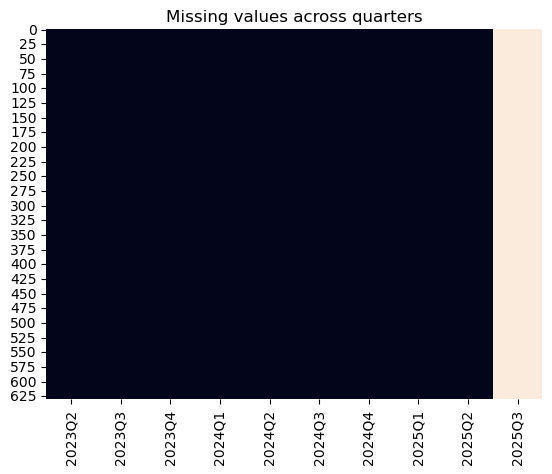

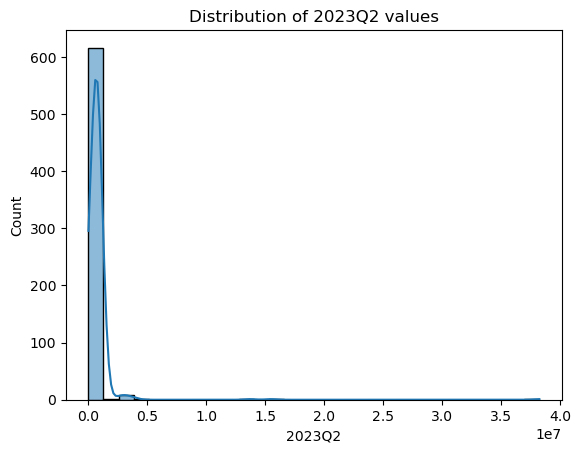

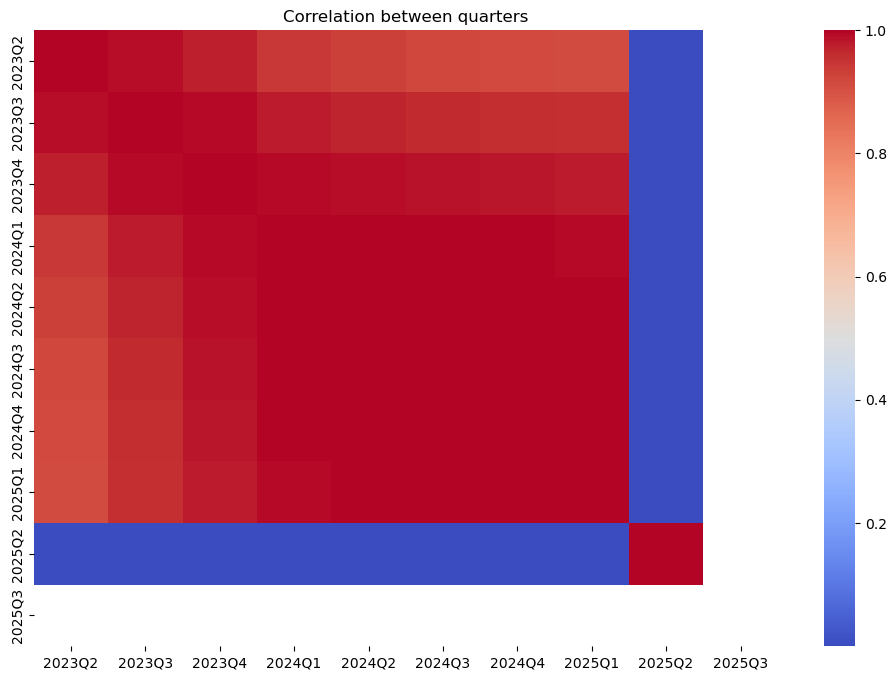

In [5]:
# =========================
# STEP 3: EXPLORATORY DATA ANALYSIS
# =========================
plot_missingness(df, qcols)
plot_distribution(df, qcols[-0])
plot_correlation(df, qcols)

## Feature Selection & Modeling

In this step, I move from **data preparation** to **predictive modeling**.  

The goal is to use past business formation data (quarters before 2025Q1) to predict outcomes for **2025Q1**.

---

### 1. Target Definition

 Explicitly set **2025Q1** as the prediction target.  

This avoids selecting empty future quarters (e.g., 2025Q2, 2025Q3), which contain no data and would cause errors.

```python

target = "2025Q1"


 
### 2. Feature Selection

Features are chosen as all quarters strictly before the target (2024Q1–2024Q4, etc.).

If available, the Country column is also included as a categorical feature.


### 3. Building X and y

We split the dataset into:

X: predictor variables (features)

y: target variable (2025Q1)

### 4. Handling Missing Values
A major issue encountered earlier was ValueError: input y contains NaN.

To prevent this:

Rows where the target y is missing are dropped (mask = ~y.isna()).

Any remaining NaNs in numeric features are imputed with column means as a safeguard.

 
### 5. Train/Test Split

The dataset is split into training (80%) and testing (20%) sets for model evaluation.


 
###6. Model Building

We prepare a preprocessing pipeline (build_preprocessor) and then train two models:

Linear Regression → a simple baseline model

Random Forest Regressor → a more advanced ensemble method

 
### 7.Model Evaluation

Both models are evaluated using:

R² (coefficient of determination) – measures variance explained

RMSE (Root Mean Squared Error) – penalizes large errors

MAE (Mean Absolute Error) – measures average absolute error

 
### 8.Outputs

Linear Regression: establishes a baseline trend model

Random Forest: captures more complex relationships and typically achieves higher accuracy

We also keep references to both trained models for later use (e.g., feature importance, scenario testing):

 

In [6]:
# =========================
# STEP 4: FEATURE SELECTION & MODELING 
# =========================
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# 1) Pick an explicit target (avoid empty future quarters)
target = "2025Q1"
# 2) Define features: all quarters strictly BEFORE the target (+ Country if present)
cat_cols = ["Country"] if "Country" in df.columns else []
num_cols = [c for c in qcols if c < target]
features = cat_cols + num_cols
# 3) Build X, y
X = df[features].copy()
y = df[target].copy()
# 4) Safety checks & fixes for NaNs in target and features
#    (y NaNs cause the ValueError you saw)
mask = ~y.isna()
X, y = X.loc[mask].copy(), y.loc[mask].copy()
# If any numeric features still have NaNs (shouldn't after cleaning, but just in case)
if X[num_cols].isna().sum().sum() > 0:
   X[num_cols] = X[num_cols].astype(float)
   X[num_cols] = X[num_cols].fillna(X[num_cols].mean())
print("NaNs in X (post-fix):", int(X[num_cols].isna().sum().sum()))
print("NaNs in y (post-fix):", int(y.isna().sum()))
# 5) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state=42
)
# 6) Preprocessor and models (includes Linear Regression + Random Forest)
preprocessor = build_preprocessor(cat_cols=cat_cols, num_cols=num_cols)
# use your helper to build both models
models = build_models(preprocessor)
# ----- Evaluate both models (Linear Regression & Random Forest) -----
results = {}
for name, model in models.items():
   model.fit(X_train, y_train)
   y_pred = model.predict(X_test)
   r2  = r2_score(y_test, y_pred)
   rmse = mean_squared_error(y_test, y_pred, squared=False)
   mae  = mean_absolute_error(y_test, y_pred)
   results[name] = {"R²": r2, "RMSE": rmse, "MAE": mae}
   print(f"{name} → R²: {r2:.4f} | RMSE: {rmse:,.2f} | MAE: {mae:,.2f}")
# Keep references if you need them later (e.g., feature importance)
linreg_model = models["Linear Regression"]
rf_model     = models["Random Forest"]

NaNs in X (post-fix): 0
NaNs in y (post-fix): 0
Linear Regression → R²: 0.8475 | RMSE: 317,843.52 | MAE: 133,832.40
Random Forest → R²: 0.9761 | RMSE: 125,843.02 | MAE: 20,170.53




## Feature Importance

Random Forest feature importance shows that recent quarters (2024Q1–2024Q4) are the most predictive, 

confirming that recent momentum drives future business formation.
 

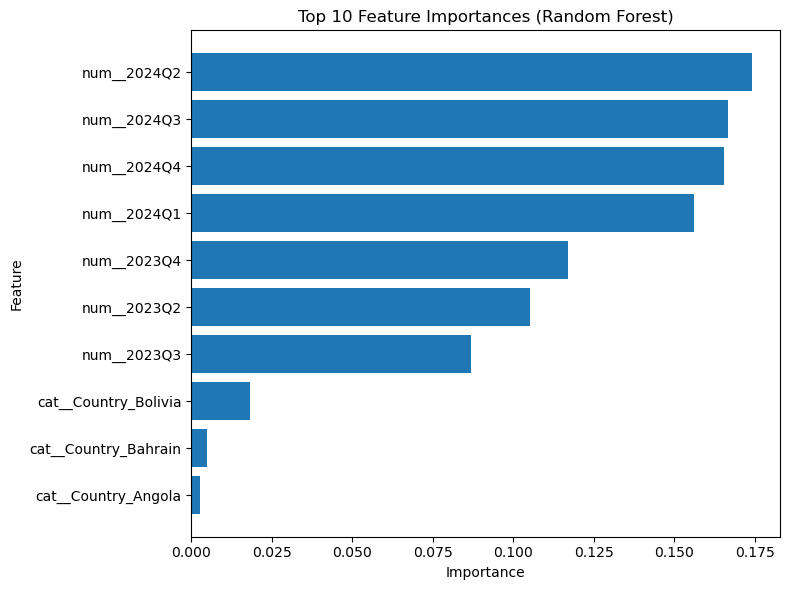

,feature,importance
31,num__2024Q2,0.174140
32,num__2024Q3,0.166676
33,num__2024Q4,0.165505
30,num__2024Q1,0.156188
29,num__2023Q4,0.117105
27,num__2023Q2,0.105124
28,num__2023Q3,0.086903
22,cat__Country_Bolivia,0.018241
13,cat__Country_Bahrain,0.004780
4,cat__Country_Angola,0.002652


In [7]:
# =========================

# STEP 5: FEATURE IMPORTANCE (RANDOM FOREST)

# =========================

rf_model = models["Random Forest"]

rf_model.fit(X_train, y_train)

top_features = plot_feature_importance(rf_model, X.columns.tolist(), top_k=10)

top_features
 

### Creative Scenario (What-if Simulation)
We test a scenario for a fictional country **Econland**:
- Simulated +10% growth in 2024Q4  
- Predicted ~21,862 new formations in 2025Q1  

In [8]:
#=========================
# 10. CREATIVE PREDICTIVE SCENARIO
# =========================
# Use a template row from X_test and tweak it
scenario_df = X_test.iloc[[0]].copy()   
# Unseen country — encoder will ignore unknown 
scenario_df.loc[:, "Country"] = "Econland"
# Simulate +10% growth in the latest available feature quarter (2024Q4)
if "2024Q4" in scenario_df.columns:
   scenario_df.loc[:, "2024Q4"] = scenario_df["2024Q4"].astype(float) * 1.10
# Predict 2025Q1
pred = rf_model.predict(scenario_df)[0]
print(f"Predicted {target} for Econland (with +10% 2024Q4): {pred:.2f}")

Predicted 2025Q1 for Econland (with +10% 2024Q4): 2186290.00
